In [1]:
pip install cartopy matplotlib pandas

Total PV potential in Kaohsiung City [ssp2]: 24951.84 MW


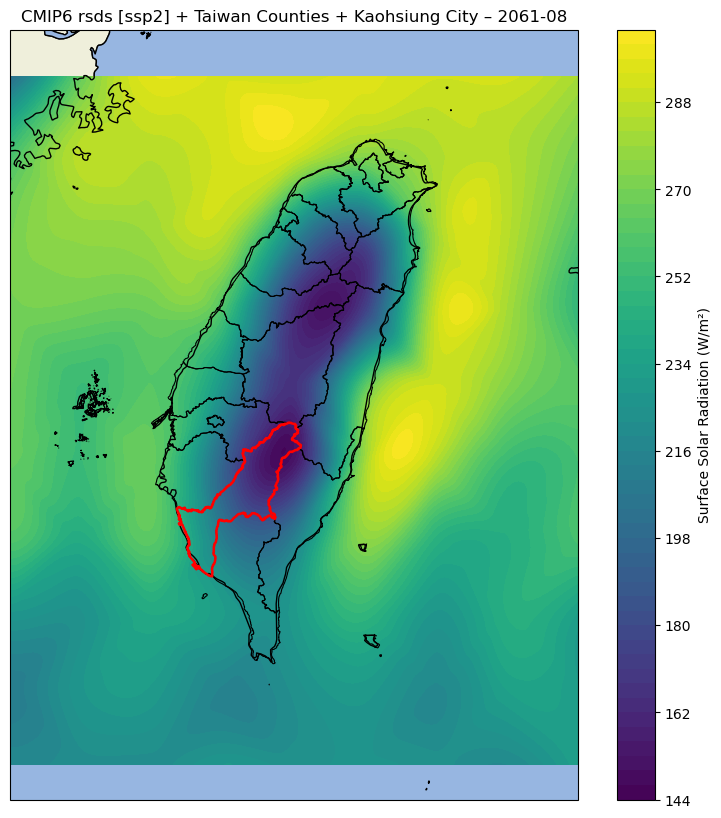

In [11]:
# ======================================
# CMIP6 rsds contour + Taiwan county boundaries + PV potential calculation (final clean version)
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata

# --------------------------------------
# 0. User selection: SSP model and target month
# --------------------------------------
ssp_target = 'ssp2'  # choose from 'ssp2', 'ssp3', 'ssp5'
target_month = '2061-08'
target_county = '高雄市'

# Map to column name in your dataset
ssp_map = {
    'ssp2': 'rsds_ssp2',
    'ssp3': 'rsds_ssp3',
    'ssp5': 'rsds_ssp5'
}
rsds_col = ssp_map[ssp_target]

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# Filter for specific month
df_month = df[df["time"].dt.strftime("%Y-%m") == target_month][["lon", "lat", rsds_col]].copy()
df_month = df_month.rename(columns={rsds_col: "rsds"})

# --------------------------------------
# 2. Interpolate data onto grid
# --------------------------------------
num_points = 300
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_month[["lon", "lat"]].values
values = df_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')

# Mask invalid values
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 3. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

# Reproject to EPSG:4326 if needed
if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

# --------------------------------------
# 4. Select target county for PV calculation
# --------------------------------------
county_row = gdf_county[gdf_county['COUNTYNAME'] == target_county]

if county_row.empty:
    raise ValueError("Target county not found in shapefile. Check spelling or field names.")

county_geom = county_row.geometry.iloc[0]
target_county_eng = county_row['COUNTYENG'].iloc[0]

# --------------------------------------
# 5. Calculate grid cell areas
# --------------------------------------
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)

for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # area in m²

# --------------------------------------
# 6. Calculate total PV potential within county
# --------------------------------------
efficiency = 0.15
panel_ratio = 0.3
total_potential = 0

for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        if masked_rsds[i,j] is ma.masked:
            continue
        point = Point(lon2d[i,j], lat2d[i,j])
        if county_geom.contains(point):
            rsds = masked_rsds[i,j]  # W/m²
            area = cell_areas[i,j]   # m²
            potential = rsds * area * efficiency * panel_ratio  # W
            total_potential += potential

# Convert to MW
total_potential_MW = total_potential / 1e6
print(f"Total PV potential in {target_county_eng} [{ssp_target}]: {total_potential_MW:.2f} MW")

# --------------------------------------
# 7. Plotting combined contour + county boundaries
# --------------------------------------
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())

# Base map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# CMIP6 rsds contour
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    transform=ccrs.PlateCarree(), cmap="viridis"
)

# County boundaries overlay
for _, row in gdf_county.iterrows():
    geom = row.geometry
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', linewidth=0.8)

# Highlight target county in red
ax.add_geometries([county_geom], crs=ccrs.PlateCarree(),
                  edgecolor='red', facecolor='none', linewidth=1.8)

# Colorbar and title
plt.colorbar(cf, ax=ax, orientation='vertical', label="Surface Solar Radiation (W/m²)")
plt.title(f"CMIP6 rsds [{ssp_target}] + Taiwan Counties + {target_county_eng} – {target_month}")
plt.show()


In [12]:

city_geom = gdf_county[gdf_county['COUNTYNAME']==target_county].geometry.iloc[0]

points_in_city = []

for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        point = Point(lon2d[i,j], lat2d[i,j])
        if city_geom.contains(point):
            points_in_city.append((lon2d[i,j], lat2d[i,j]))

print(f"Number of grid points within {target_county}: {len(points_in_city)}")


Number of grid points within 高雄市: 1173


Calculating ssp2 PV potential:   0%|          | 0/12 [00:00<?, ?it/s]

Calculating ssp5 PV potential: 100%|██████████| 12/12 [00:39<00:00,  3.32s/it]


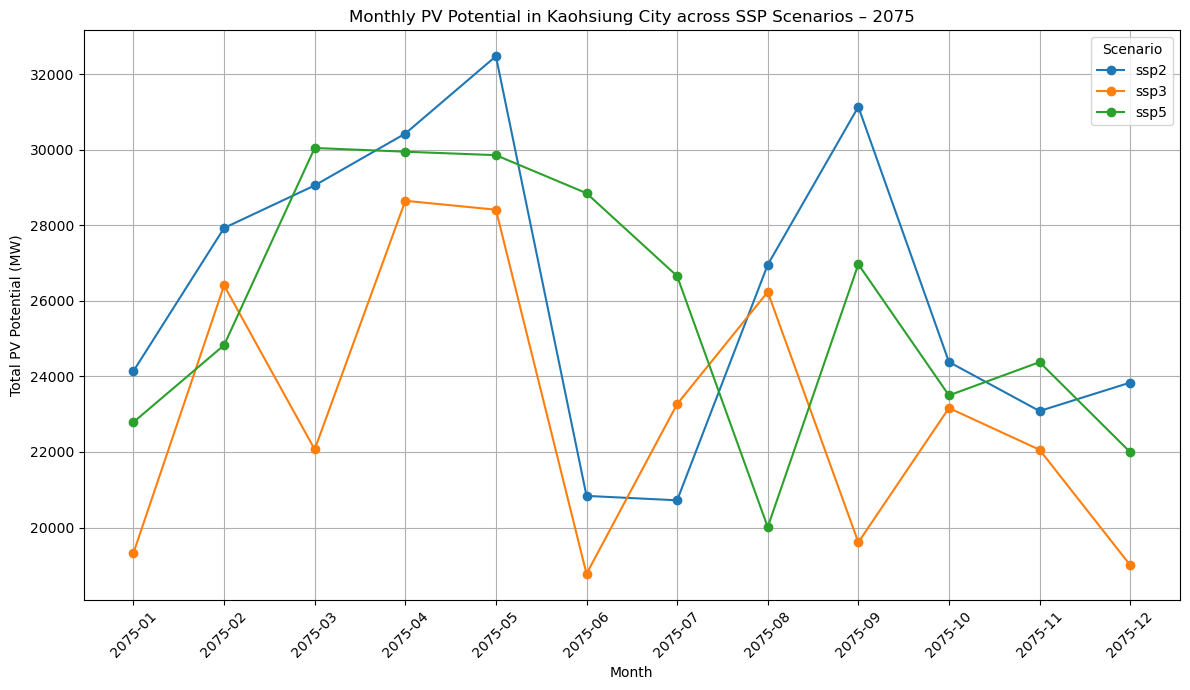

In [13]:
# --------------------------------------
# Calculate monthly PV potential for a full year across all SSP scenarios
# --------------------------------------

from tqdm import tqdm


# Define SSP models and mapping
ssp_targets = ['ssp2', 'ssp3', 'ssp5']
ssp_map = {
    'ssp2': 'rsds_ssp2',
    'ssp3': 'rsds_ssp3',
    'ssp5': 'rsds_ssp5'
}


months = [f"{target_year}-{month:02d}" for month in range(1, 13)]

results = []

for ssp_target in ssp_targets:
    rsds_col = ssp_map[ssp_target]

    for month in tqdm(months, desc=f"Calculating {ssp_target} PV potential"):
        # Filter data for current month
        df_month = df[df["time"].dt.strftime("%Y-%m") == month][["lon", "lat", rsds_col]].copy()
        df_month = df_month.rename(columns={rsds_col: "rsds"})

        # Interpolate data onto grid
        values = df_month["rsds"].values
        points = df_month[["lon", "lat"]].values
        grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')
        masked_rsds = ma.masked_invalid(grid_rsds)

        # Calculate total PV potential within county
        total_potential = 0

        for i in range(len(lat_grid)):
            for j in range(len(lon_grid)):
                if masked_rsds[i,j] is ma.masked:
                    continue
                point = Point(lon2d[i,j], lat2d[i,j])
                if county_geom.contains(point):
                    rsds = masked_rsds[i,j]  # W/m²
                    area = cell_areas[i,j]   # m²
                    potential = rsds * area * efficiency * panel_ratio  # W
                    total_potential += potential

        total_potential_MW = total_potential / 1e6
        results.append({
            "Month": month,
            "Scenario": ssp_target,
            "Total_PVOUT_MW": total_potential_MW
        })

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# --------------------------------------
# Plot multi-line chart of monthly PVOUT across scenarios
# --------------------------------------
plt.figure(figsize=(12,7))

for ssp_target in ssp_targets:
    df_subset = df_results[df_results["Scenario"] == ssp_target]
    plt.plot(df_subset["Month"], df_subset["Total_PVOUT_MW"], marker='o', label=ssp_target)

plt.xticks(rotation=45)
plt.title(f"Monthly PV Potential in {target_county_eng} across SSP Scenarios – {target_year}")
plt.ylabel("Total PV Potential (MW)")
plt.xlabel("Month")
plt.legend(title="Scenario")
plt.grid(True)
plt.tight_layout()
plt.show()


Calculating ssp5 PV potential: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


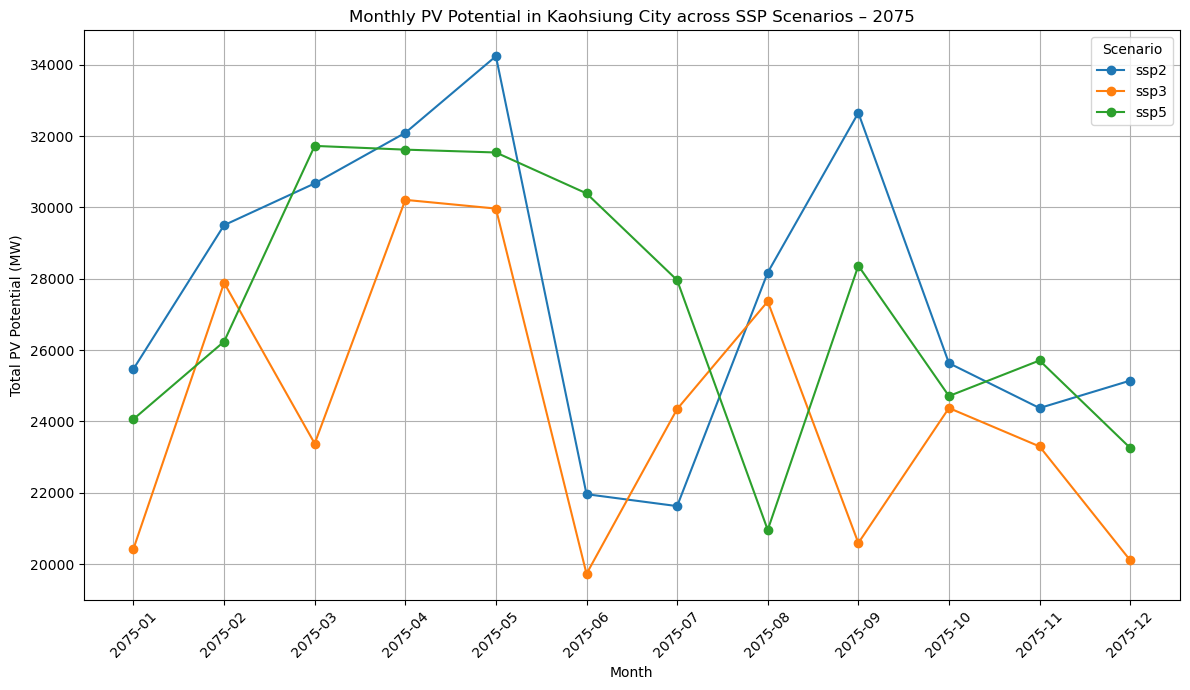

In [14]:
# ======================================
# CMIP6 rsds monthly PVOUT comparison across SSP scenarios (target county only)
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata
from tqdm import tqdm

# --------------------------------------
# 0. User selection: target year and county
# --------------------------------------
target_year = '2075'
target_county = '高雄市'

# Define SSP models and mapping
ssp_targets = ['ssp2', 'ssp3', 'ssp5']
ssp_map = {
    'ssp2': 'rsds_ssp2',
    'ssp3': 'rsds_ssp3',
    'ssp5': 'rsds_ssp5'
}

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# --------------------------------------
# 2. Generate interpolation grid
# --------------------------------------
num_points = 40
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

# --------------------------------------
# 3. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

# Reproject to EPSG:4326 if needed
if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

# --------------------------------------
# 4. Select target county
# --------------------------------------
county_row = gdf_county[gdf_county['COUNTYNAME'] == target_county]

if county_row.empty:
    raise ValueError("Target county not found in shapefile. Check spelling or field names.")

county_geom = county_row.geometry.iloc[0]
target_county_eng = county_row['COUNTYENG'].iloc[0]

# --------------------------------------
# 5. Calculate grid cell areas
# --------------------------------------
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)

for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # area in m²

# --------------------------------------
# 6. Calculate monthly PV potential for all SSPs in target year
# --------------------------------------
efficiency = 0.15
panel_ratio = 0.3

months = [f"{target_year}-{month:02d}" for month in range(1, 13)]
results = []

for ssp_target in ssp_targets:
    rsds_col = ssp_map[ssp_target]

    for month in tqdm(months, desc=f"Calculating {ssp_target} PV potential"):
        # Filter for current month
        df_month = df[df["time"].dt.strftime("%Y-%m") == month][["lon", "lat", rsds_col]].copy()
        df_month = df_month.rename(columns={rsds_col: "rsds"})

        # Interpolate data onto grid
        points = df_month[["lon", "lat"]].values
        values = df_month["rsds"].values
        grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')
        masked_rsds = ma.masked_invalid(grid_rsds)

        # Calculate total PV potential within county
        total_potential = 0
        for i in range(len(lat_grid)):
            for j in range(len(lon_grid)):
                if masked_rsds[i,j] is ma.masked:
                    continue
                point = Point(lon2d[i,j], lat2d[i,j])
                if county_geom.contains(point):
                    rsds = masked_rsds[i,j]  # W/m²
                    area = cell_areas[i,j]   # m²
                    potential = rsds * area * efficiency * panel_ratio  # W
                    total_potential += potential

        total_potential_MW = total_potential / 1e6
        results.append({
            "Month": month,
            "Scenario": ssp_target,
            "Total_PVOUT_MW": total_potential_MW
        })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# --------------------------------------
# 7. Plot multi-line chart of monthly PVOUT across SSP scenarios
# --------------------------------------
plt.figure(figsize=(12,7))

for ssp_target in ssp_targets:
    df_subset = df_results[df_results["Scenario"] == ssp_target]
    plt.plot(df_subset["Month"], df_subset["Total_PVOUT_MW"], marker='o', label=ssp_target)

plt.xticks(rotation=45)
plt.title(f"Monthly PV Potential in {target_county_eng} across SSP Scenarios – {target_year}")
plt.ylabel("Total PV Potential (MW)")
plt.xlabel("Month")
plt.legend(title="Scenario")
plt.grid(True)
plt.tight_layout()
plt.show()


Volatility (CV) for ssp2 in Kaohsiung City (2075): 0.153


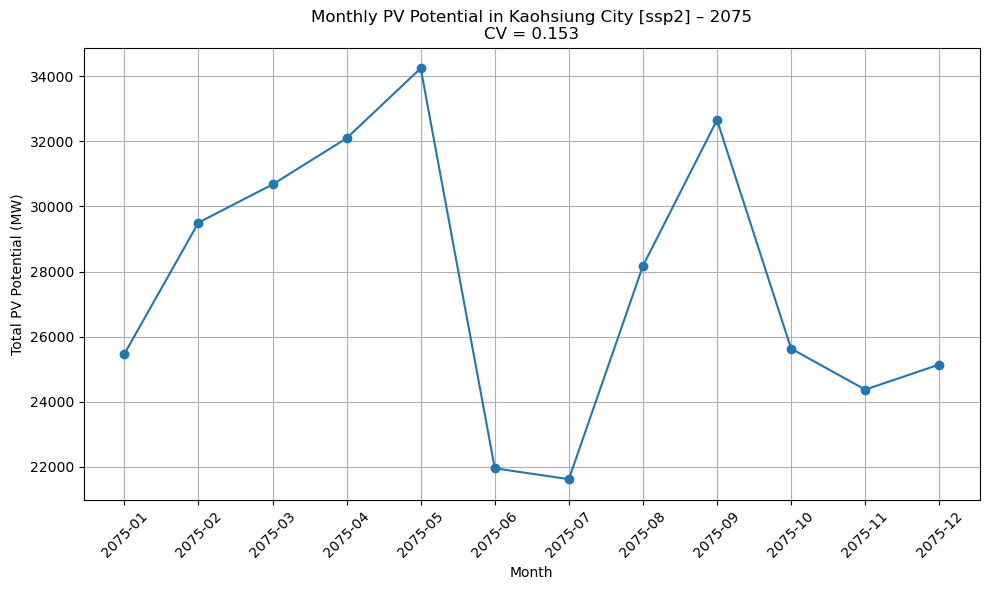

In [15]:
# --------------------------------------
# 8. Calculate CV for selected SSP scenario
# --------------------------------------

# Choose SSP to analyze
selected_ssp = 'ssp2'

# Filter data for selected SSP
df_ssp = df_results[df_results["Scenario"] == selected_ssp]

# Calculate mean and standard deviation
mean_pv = df_ssp["Total_PVOUT_MW"].mean()
std_pv = df_ssp["Total_PVOUT_MW"].std()

# Calculate CV
cv = std_pv / mean_pv

print(f"Volatility (CV) for {selected_ssp} in {target_county_eng} ({target_year}): {cv:.3f}")

# Optional: plot with annotation
plt.figure(figsize=(10,6))
plt.plot(df_ssp["Month"], df_ssp["Total_PVOUT_MW"], marker='o')
plt.xticks(rotation=45)
plt.title(f"Monthly PV Potential in {target_county_eng} [{selected_ssp}] – {target_year}\nCV = {cv:.3f}")
plt.ylabel("Total PV Potential (MW)")
plt.xlabel("Month")
plt.grid(True)
plt.tight_layout()
plt.show()


Calculating August PV potential by year: 100%|██████████| 85/85 [00:05<00:00, 16.92it/s]


Interannual CV for August PVOUT in New Taipei City under ssp3 (2015-2099): 0.070


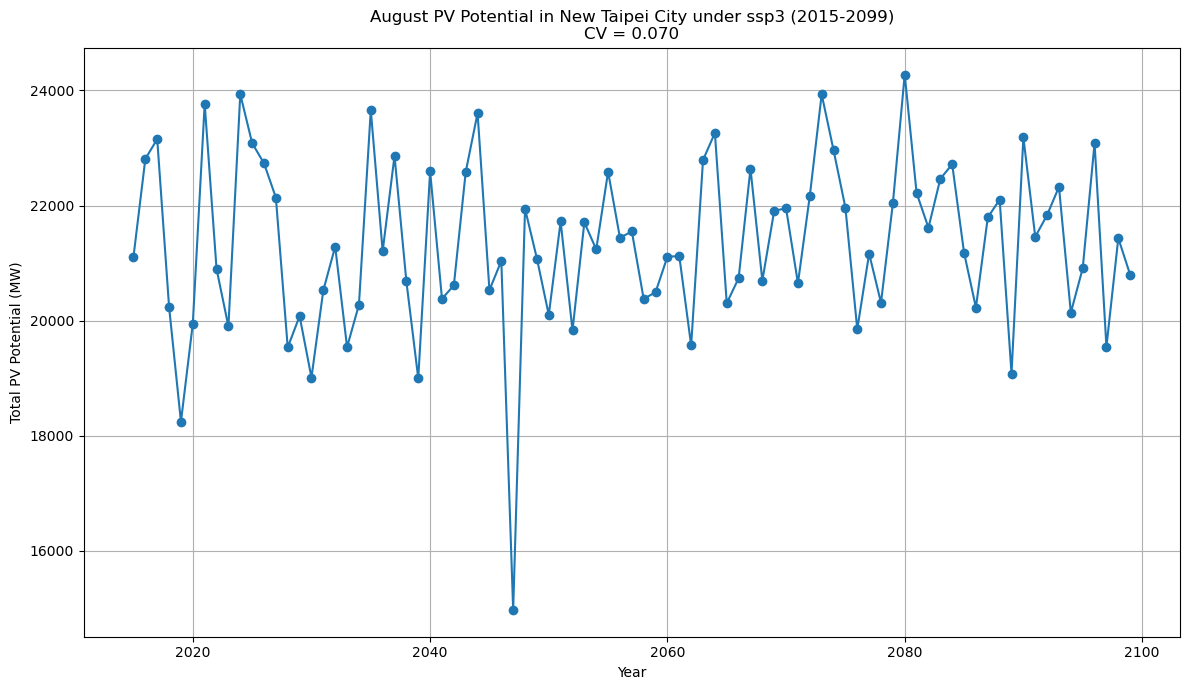

In [21]:
# ======================================
# CMIP6 rsds target month PVOUT time series (2015-2099) with CV for 高雄市 under SSP2
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata
from tqdm import tqdm
import calendar

# --------------------------------------
# 0. User selection
# --------------------------------------
target_month_num = 8  # set target month number here, e.g. 6 for June
target_county = '新北市'
ssp_target = 'ssp3'

ssp_map = {
    'ssp2': 'rsds_ssp2',
    'ssp3': 'rsds_ssp3',
    'ssp5': 'rsds_ssp5'
}
rsds_col = ssp_map[ssp_target]

# Get month name for dynamic titles
target_month_name = calendar.month_name[target_month_num]

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# Filter for target month across all years
df_month = df[df["time"].dt.month == target_month_num][["time", "lon", "lat", rsds_col]].copy()
df_month = df_month.rename(columns={rsds_col: "rsds"})

# --------------------------------------
# 2. Generate interpolation grid
# --------------------------------------
num_points = 50
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

# --------------------------------------
# 3. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

# Reproject to EPSG:4326 if needed
if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

# --------------------------------------
# 4. Select target county
# --------------------------------------
county_row = gdf_county[gdf_county['COUNTYNAME'] == target_county]

if county_row.empty:
    raise ValueError("Target county not found in shapefile. Check spelling or field names.")

county_geom = county_row.geometry.iloc[0]
target_county_eng = county_row['COUNTYENG'].iloc[0]

# --------------------------------------
# 5. Calculate grid cell areas
# --------------------------------------
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)

for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # area in m²

# --------------------------------------
# 6. Calculate annual PV potential (2015-2099) for target month
# --------------------------------------
efficiency = 0.15
panel_ratio = 0.3

years = np.arange(2015, 2100)
results = []

for year in tqdm(years, desc=f"Calculating {target_month_name} PV potential by year"):
    df_year = df_month[df_month["time"].dt.year == year][["lon", "lat", "rsds"]].copy()
    if df_year.empty:
        continue

    # Interpolate data onto grid
    points = df_year[["lon", "lat"]].values
    values = df_year["rsds"].values
    grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')
    masked_rsds = ma.masked_invalid(grid_rsds)

    # Calculate total PV potential within county
    total_potential = 0
    for i in range(len(lat_grid)):
        for j in range(len(lon_grid)):
            if masked_rsds[i,j] is ma.masked:
                continue
            point = Point(lon2d[i,j], lat2d[i,j])
            if county_geom.contains(point):
                rsds = masked_rsds[i,j]  # W/m²
                area = cell_areas[i,j]   # m²
                potential = rsds * area * efficiency * panel_ratio  # W
                total_potential += potential

    total_potential_MW = total_potential / 1e6
    results.append({
        "Year": year,
        "Total_PVOUT_MW": total_potential_MW
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# --------------------------------------
# 7. Calculate CV across years for target month
# --------------------------------------
mean_pv = df_results["Total_PVOUT_MW"].mean()
std_pv = df_results["Total_PVOUT_MW"].std()
cv = std_pv / mean_pv

print(f"Interannual CV for {target_month_name} PVOUT in {target_county_eng} under {ssp_target} (2015-2099): {cv:.3f}")

# --------------------------------------
# 8. Plot line chart of PVOUT over years with CV annotated
# --------------------------------------
plt.figure(figsize=(12,7))
plt.plot(df_results["Year"], df_results["Total_PVOUT_MW"], marker='o')
plt.title(f"{target_month_name} PV Potential in {target_county_eng} under {ssp_target} (2015-2099)\nCV = {cv:.3f}")
plt.ylabel("Total PV Potential (MW)")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


Processing counties:   0%|          | 0/22 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_26708\2641441485.py:128: RuntimeWarning: invalid value encountered in scalar divide
  cv = std_output / mean_output
Processing counties:  50%|█████     | 11/22 [09:16<10:40, 58.24s/it]C:\Users\User\AppData\Local\Temp\ipykernel_26708\2641441485.py:128: RuntimeWarning: invalid value encountered in scalar divide
  cv = std_output / mean_output
Processing counties:  59%|█████▉    | 13/22 [11:23<09:01, 60.19s/it]C:\Users\User\AppData\Local\Temp\ipykernel_26708\2641441485.py:128: RuntimeWarning: invalid value encountered in scalar divide
  cv = std_output / mean_output
Processing counties:  82%|████████▏ | 18/22 [14:52<03:04, 46.24s/it]C:\Users\User\AppData\Local\Temp\ipykernel_26708\2641441485.py:128: RuntimeWarning: invalid value encountered in scalar divide
  cv = std_output / mean_output
Processing counties: 100%|██████████| 22/22 [18:38<00:00, 50.83s/it]


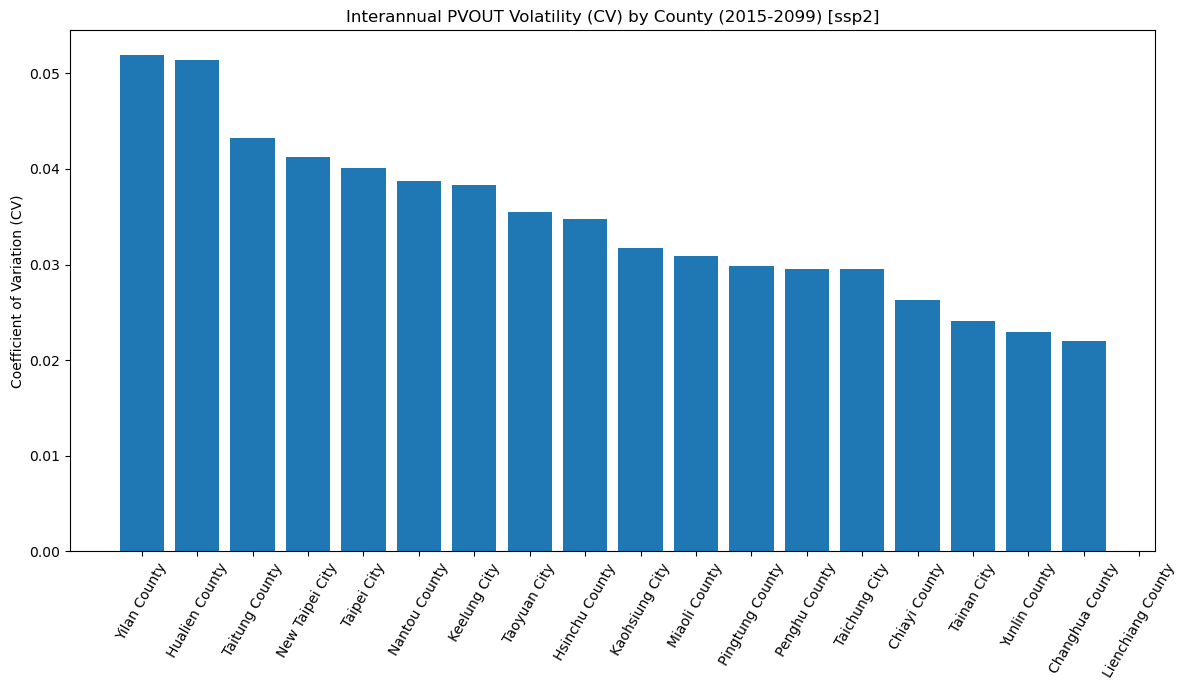

In [23]:
# ======================================
# Calculate annual PVOUT CV for all counties (2015-2099) and plot bar chart
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata
from tqdm import tqdm

# --------------------------------------
# 0. User selection
# --------------------------------------
ssp_target = 'ssp2'

ssp_map = {
    'ssp2': 'rsds_ssp2',
    'ssp3': 'rsds_ssp3',
    'ssp5': 'rsds_ssp5'
}
rsds_col = ssp_map[ssp_target]

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# Filter only required column to reduce memory
df = df[["time", "lon", "lat", rsds_col]].rename(columns={rsds_col: "rsds"})

# --------------------------------------
# 2. Generate interpolation grid
# --------------------------------------
num_points = 40
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

# --------------------------------------
# 3. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

# Reproject to EPSG:4326 if needed
if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

# --------------------------------------
# 4. Calculate grid cell areas
# --------------------------------------
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)

for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # area in m²

# --------------------------------------
# 5. Loop through each county and calculate annual PVOUT
# --------------------------------------
efficiency = 0.15
panel_ratio = 0.3
years = np.arange(2015, 2100)

county_cv_results = []

for idx, row in tqdm(gdf_county.iterrows(), total=len(gdf_county), desc="Processing counties"):
    county_name = row['COUNTYNAME']
    county_eng = row['COUNTYENG']
    county_geom = row.geometry

    annual_outputs = []

    for year in years:
        # Filter data for this year
        df_year = df[df["time"].dt.year == year].copy()
        if df_year.empty:
            continue

        # Calculate monthly PVOUT for the year
        monthly_outputs = []

        for month in range(1,13):
            df_month = df_year[df_year["time"].dt.month == month][["lon", "lat", "rsds"]].copy()
            if df_month.empty:
                continue

            # Interpolate
            points = df_month[["lon", "lat"]].values
            values = df_month["rsds"].values
            grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')
            masked_rsds = ma.masked_invalid(grid_rsds)

            # Calculate total PV potential within county
            total_potential = 0
            for i in range(len(lat_grid)):
                for j in range(len(lon_grid)):
                    if masked_rsds[i,j] is ma.masked:
                        continue
                    point = Point(lon2d[i,j], lat2d[i,j])
                    if county_geom.contains(point):
                        rsds = masked_rsds[i,j]  # W/m²
                        area = cell_areas[i,j]   # m²
                        potential = rsds * area * efficiency * panel_ratio  # W
                        total_potential += potential

            total_potential_MW = total_potential / 1e6
            monthly_outputs.append(total_potential_MW)

        # Sum monthly outputs to get annual output
        annual_total = np.sum(monthly_outputs)
        annual_outputs.append(annual_total)

    # Calculate mean, std, CV for annual outputs
    if len(annual_outputs) > 1:
        mean_output = np.mean(annual_outputs)
        std_output = np.std(annual_outputs)
        cv = std_output / mean_output
    else:
        mean_output = std_output = cv = np.nan  # Not enough data

    county_cv_results.append({
        "County": county_name,
        "County_Eng": county_eng,
        "Mean_Annual_PVOUT_MW": mean_output,
        "Std_Annual_PVOUT_MW": std_output,
        "CV": cv
    })

# Convert results to DataFrame
df_cv = pd.DataFrame(county_cv_results)

# --------------------------------------
# 6. Plot bar chart of CV by county
# --------------------------------------
df_cv_sorted = df_cv.sort_values(by="CV", ascending=False)

plt.figure(figsize=(12,7))
plt.bar(df_cv_sorted["County_Eng"], df_cv_sorted["CV"])
plt.xticks(rotation=60)
plt.ylabel("Coefficient of Variation (CV)")
plt.title(f"Interannual PVOUT Volatility (CV) by County (2015-2099) [{ssp_target}]")
plt.tight_layout()
plt.show()
